In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
import keras.datasets as kds

import numpy as np
import matplotlib.pyplot as plt

# Bibliotecas utilizadas para projeção / redução de dimensionalidade
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA, PCA

2024-09-01 01:41:48.100957: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-01 01:41:48.102680: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-01 01:41:48.133711: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-01 01:41:48.134432: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-01 01:41:49.059771: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
num_classes = 10
input_shape = (32, 32, 3)

# Carga dos dados (keras.datasets)
(x_train, y_train), (x_test, y_test) = kds.cifar10.load_data()


assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)


# Normalização das features
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


170498071/170498071 [==============================] - 9s 0us/step
(50000, 3072)
(10000, 3072)


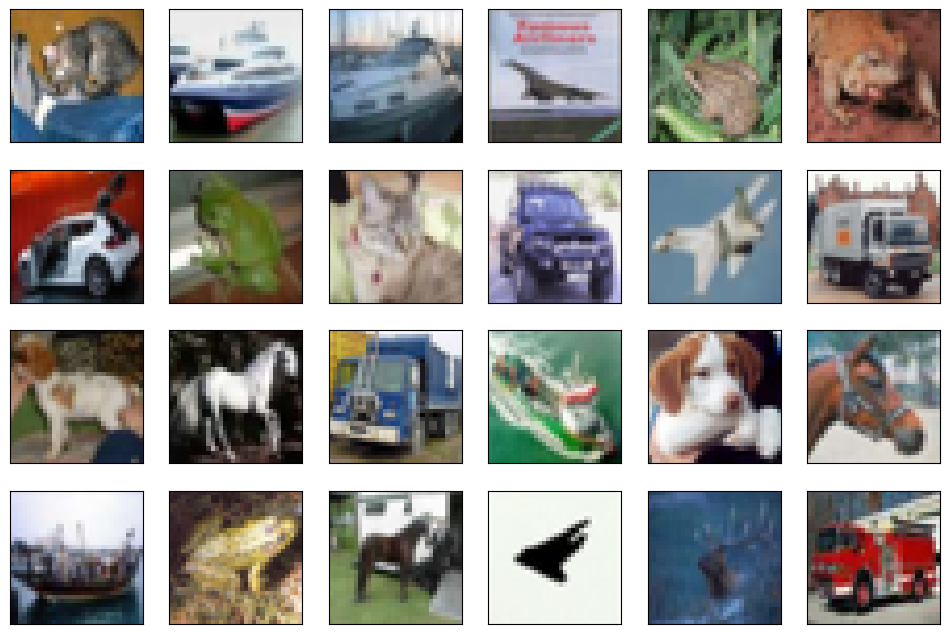

In [4]:
plt.figure(figsize=(12, 8))
for i in range(24):
    ax = plt.subplot(4, 6, i + 1)
    plt.imshow(x_test[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [5]:
# Função de amostragem
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

original_dim = 3072 # 32x32x3
latent_dim = 10

In [6]:
# Definição do encoder
inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(256, activation='relu')(inputs)
h = layers.Dense(128, activation='relu')(h)
h = layers.Dense(64, activation='relu')(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)
z = layers.Lambda(sampling)([z_mean, z_log_sigma])
encoder01 = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

2024-09-01 01:43:03.914362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-01 01:43:03.915171: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# Definição do decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(64, activation='relu')(latent_inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder01 = keras.Model(latent_inputs, outputs, name='decoder')

In [8]:
# Criação do VAE
outputs = decoder01(encoder01(inputs)[2]) # decoder recebe z como entrada (saída 2 do encoder)
vae01 = keras.Model(inputs, outputs, name='vae_mlp')
vae01.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 encoder (Functional)        [(None, 10),              829140    
                              (None, 10),                        
                              (None, 10)]                        
                                                                 
 decoder (Functional)        (None, 3072)              831552    
                                                                 
Total params: 1660692 (6.34 MB)
Trainable params: 1660692 (6.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae01.add_loss(vae_loss)

In [11]:
vae01.compile(optimizer='adam')

history = vae01.fit(x_train, x_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(x_test, x_test),
                    verbose=1)

Epoch 1/10
196/196 [==============================] - 6s 26ms/step - loss: 1863.1505 - val_loss: 1856.6686
Epoch 2/10
196/196 [==============================] - 5s 26ms/step - loss: 1852.2385 - val_loss: 1855.5461
Epoch 3/10
196/196 [==============================] - 5s 24ms/step - loss: 1849.5426 - val_loss: 1851.9827
Epoch 4/10
196/196 [==============================] - 5s 25ms/step - loss: 1847.8519 - val_loss: 1850.4382
Epoch 5/10
196/196 [==============================] - 6s 29ms/step - loss: 1846.9509 - val_loss: 1852.6992
Epoch 6/10
196/196 [==============================] - 6s 30ms/step - loss: 1846.1947 - val_loss: 1850.1404
Epoch 7/10
196/196 [==============================] - 5s 25ms/step - loss: 1845.9673 - val_loss: 1849.5608
Epoch 8/10
196/196 [==============================] - 5s 27ms/step - loss: 1845.4059 - val_loss: 1852.1658
Epoch 9/10
196/196 [==============================] - 5s 25ms/step - loss: 1845.4016 - val_loss: 1848.5342
Epoch 10/10
196/196 [================

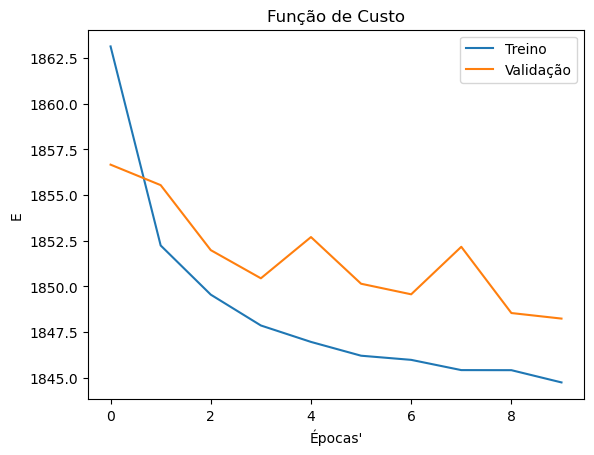

In [12]:
plt.figure()
plt.plot(history.history["loss"], label = "Treino")
plt.plot(history.history["val_loss"], label = "Validação")
plt.title("Função de Custo")
plt.ylabel("E")
plt.xlabel("Épocas'")
plt.legend()
plt.show()

40/40 [==============================] - 0s 3ms/step


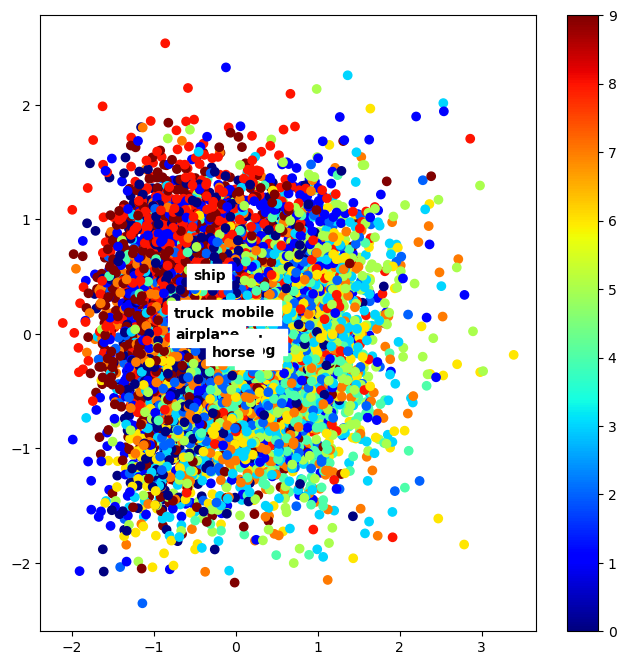

In [17]:
class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
x_test_encoded = encoder01.predict(x_test, batch_size=256)[2]

plt.figure(figsize=(8, 8))
x_emb = PCA(n_components=2).fit_transform(x_test_encoded)
scatter = plt.scatter(x_emb[:, 0], x_emb[:, 1], c=y_test, cmap=plt.cm.jet)

class_means = []
for i in range(num_classes):
    class_indices = np.where(y_test == i)[0]
    class_mean = np.mean(x_emb[class_indices], axis=0)
    class_means.append(class_mean)

for i, (x, y) in enumerate(class_means):
    label = i
    plt.annotate(
        class_names[label],
        (x, y),
        fontsize=10,
        color='black',
        weight='bold',
        backgroundcolor='white',
        ha='center',
        va='center'
    )

plt.colorbar(scatter)
plt.show()